In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
data = pd.read_csv('train_clean.csv')
data

,Unnamed: 0,Date,year,month,day,hour,t-3,t-2,t-1,t
0,3,2011-10-03,2011,10,3,0,81140.56,26705.86,29715.07,65483.31
1,4,2011-10-04,2011,10,4,0,26705.86,29715.07,65483.31,79376.79
2,5,2011-10-05,2011,10,5,0,29715.07,65483.31,79376.79,68526.20
3,6,2011-10-06,2011,10,6,0,65483.31,79376.79,68526.20,180560.11
4,7,2011-10-07,2011,10,7,0,79376.79,68526.20,180560.11,92282.49
...,...,...,...,...,...,...,...,...,...,...
1911,1914,2016-12-26,2016,12,26,0,4784.09,23019.00,6686.47,18243.22
1912,1915,2016-12-27,2016,12,27,0,23019.00,6686.47,18243.22,48564.55
1913,1916,2016-12-28,2016,12,28,0,6686.47,18243.22,48564.55,31083.69
1914,1917,2016-12-29,2016,12,29,0,18243.22,48564.55,31083.69,33962.80


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
ts = data['t']

In [ ]:
ts = ts.resample('1M').sum()

In [8]:
ts = ts.reset_index()

In [9]:
ts

,Date,t
0,2011-10-03,65483.31
1,2011-10-04,79376.79
2,2011-10-05,68526.20
3,2011-10-06,180560.11
4,2011-10-07,92282.49
...,...,...
1911,2016-12-26,18243.22
1912,2016-12-27,48564.55
1913,2016-12-28,31083.69
1914,2016-12-29,33962.80


In [6]:
ts = ts[ts['Date'] > '2011-12-31']

In [68]:
sc = MinMaxScaler()
ts['t'] = sc.fit_transform(ts.t.values.reshape(-1, 1))

/tmp/ipykernel_1433/4099832328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['t'] = sc.fit_transform(ts.t.values.reshape(-1, 1))


In [10]:
ts

,Date,t
0,2011-10-03,65483.31
1,2011-10-04,79376.79
2,2011-10-05,68526.20
3,2011-10-06,180560.11
4,2011-10-07,92282.49
...,...,...
1911,2016-12-26,18243.22
1912,2016-12-27,48564.55
1913,2016-12-28,31083.69
1914,2016-12-29,33962.80


In [11]:
train = ts[ts['Date'] < '2016-01-01']
ttest  = ts[ts['Date'] >= '2016-01-01']

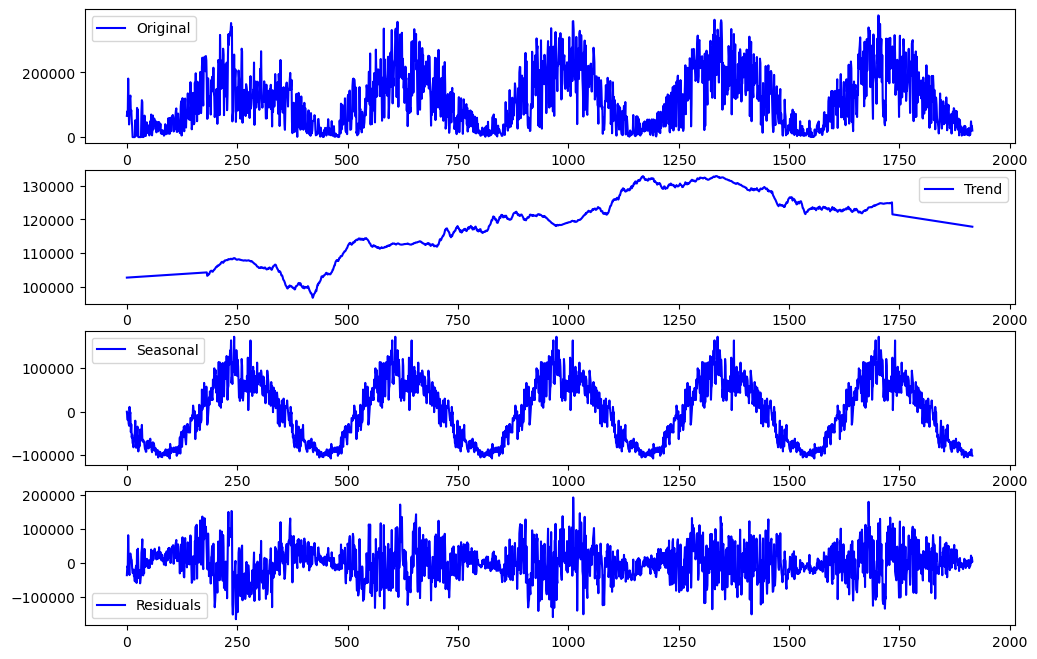

In [12]:
decomposition = seasonal_decompose(ts.t, 
                                   model='additive', 
                                   extrapolate_trend='freq',
                                   period=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ts.t, label='Original', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.show()

### 4. Remove Seasonality && Test Dick-Fuller

In [13]:
from statsmodels.tsa.stattools import adfuller

def perform_ADF_test(X):
    ADF_test = adfuller(X)
    print('ADF Statistic: %f' % ADF_test[0])
    print('p-value: %.25f' % ADF_test[1])
    print('Critical Values:')
    for key, value in ADF_test[4].items():
        print('\t%s: %.5f' % (key, value))

In [14]:
perform_ADF_test(ts.t)

ADF Statistic: -2.885751
p-value: 0.0470301749215574910190085
Critical Values:
	1%: -3.43380
	5%: -2.86306
	10%: -2.56758


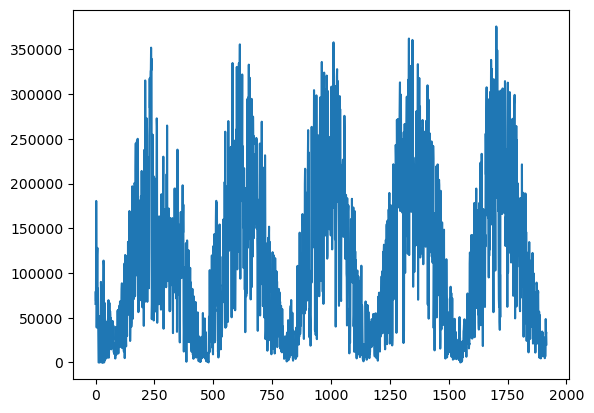

In [15]:
plt.plot(ts.t)
plt.show()

### 5. Create ACF and PACF plots & determine the p and q values:

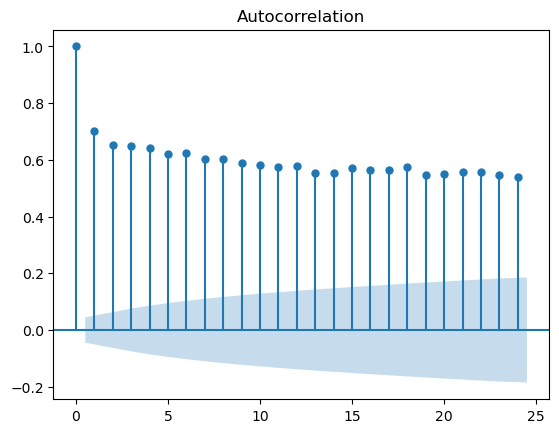

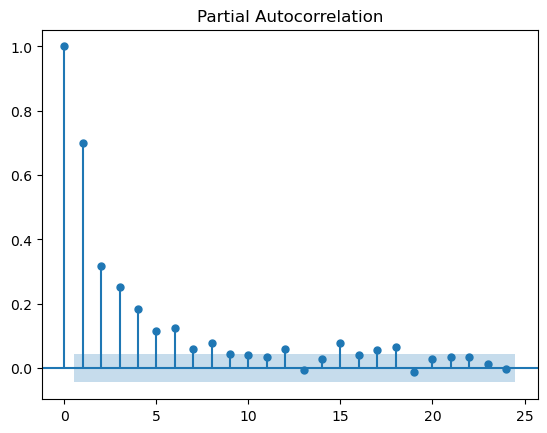

In [16]:
plot_acf(ts.t.values[1:], lags=24)
plt.show()

plot_pacf(ts.t.values[1:], lags=24)
plt.show()

### 6. ARIMA: creating the model

In [16]:
warnings.filterwarnings("ignore")

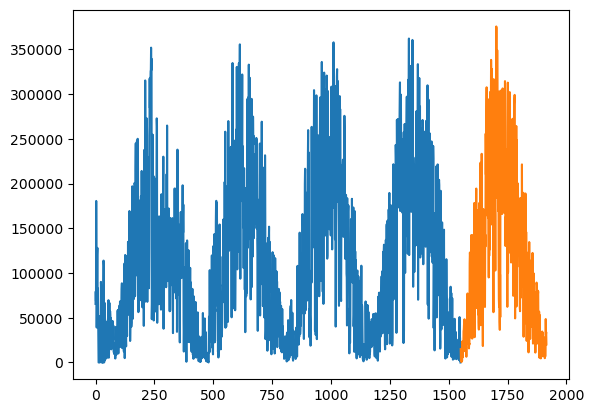

In [17]:
plt.plot(train.t)
plt.plot(ttest.t)
plt.show()

#### Greedy Search

In [18]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import datetime

<ipython-input-18-7c5167411ed3>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [76]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order,
                    seasonal_order=sorder,
                    trend=trend,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))


# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models


In [118]:
series = pd.read_csv('train_clean.csv')
ttest = pd.read_csv("test_clean.csv")

In [119]:
train = series['t']
ttest = ttest[['t']]

In [120]:
train

0        65483.31
1        79376.79
2        68526.20
3       180560.11
4        92282.49
          ...    
1911     18243.22
1912     48564.55
1913     31083.69
1914     33962.80
1915     20204.97
Name: t, Length: 1916, dtype: float64

In [121]:
ttest.reset_index(drop=True, inplace=True)

data = []

data.insert(0, {'t': 24621.90})
data.insert(0, {'t': 39376.39})
data.insert(0, {'t': 40633.85})

ttest = pd.concat([pd.DataFrame(data), ttest], ignore_index=True)

In [122]:
warnings.filterwarnings("ignore")
yhat = []
for i in range(0, 365):
    print(i)
    model = sm.tsa.arima.ARIMA(train, 
                    order=(3, 0, 3),
                    seasonal_order=(0, 1, 0, 365),
                    trend='n',
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    # fit model
    model_fit = model.fit(method='innovations_mle',
                          low_memory=True,
                          cov_type='none')
    
    d1 = model_fit.predict(start=len(history), 
                           end=len(history))
    train = train.append(pd.Series(ttest['t'][i]), 
                         ignore_index=True)
    
    yhat.append(d1.values[0])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

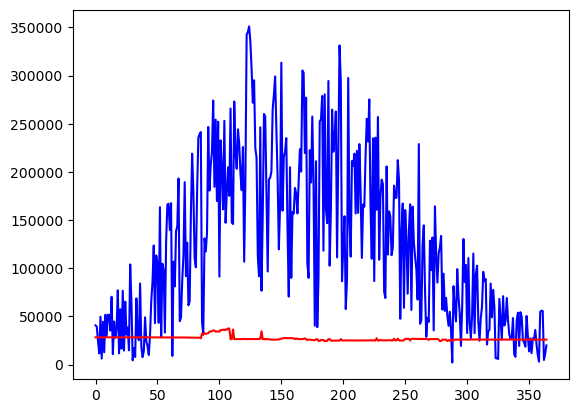

In [124]:
plt.plot(ttest.t.values, color="blue")
plt.plot(yhat, color="red")
plt.show()

In [125]:
r2_score(ttest.t.values, yhat)

-1.2434271629819555